In [1]:
import trimesh

scene = trimesh.Scene()

In [2]:
import torch
import numpy as np
import os
import shutil
from tqdm import tqdm
import yaml

import sys
import os

# models
from my_code.models.diag_conditional import DiagConditionedUnet
from diffusers import DDPMScheduler

import my_code.datasets.template_dataset as template_dataset

import my_code.diffusion_training_sign_corr.data_loading as data_loading

import networks.diffusion_network as diffusion_network
import matplotlib.pyplot as plt
import my_code.utils.plotting_utils as plotting_utils
import utils.fmap_util as fmap_util
import metrics.geodist_metric as geodist_metric
from my_code.sign_canonicalization.training import predict_sign_change
import argparse
from pyFM_fork.pyFM.refine.zoomout import zoomout_refine
import my_code.utils.zoomout_custom as zoomout_custom
from utils.shape_util import compute_geodesic_distmat
from my_code.diffusion_training_sign_corr.test.test_diffusion_cond import select_p2p_map_dirichlet, log_to_database, parse_args
import accelerate

tqdm._instances.clear()

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
import importlib
importlib.reload(zoomout_custom)

<module 'my_code.utils.zoomout_custom' from '/home/s94zalek_hpc/shape_matching/my_code/utils/zoomout_custom.py'>

In [54]:
def get_geo_error(
    p2p_first, p2p_second,
    evecs_first, evecs_second,
    corr_first, corr_second,
    num_evecs, apply_zoomout,
    dist_x,
    regularized,
    evecs_trans_first=None, evecs_trans_second=None,
    evals_first=None, evals_second=None,
    return_p2p=False, return_Cxy=False,
    A2=None
    ):
        
    if regularized:
        Cxy = fmnet.compute_functional_map(
            evecs_trans_second[:num_evecs, p2p_second].unsqueeze(0),
            evecs_trans_first[:num_evecs, p2p_first].unsqueeze(0),
            evals_second[:num_evecs].unsqueeze(0),
            evals_first[:num_evecs].unsqueeze(0), 
        )[0].T
        
    else:
        Cxy = torch.linalg.lstsq(
            evecs_second[:, :num_evecs][p2p_second],
            evecs_first[:, :num_evecs][p2p_first]
            ).solution
    
    
    if apply_zoomout:
        Cxy = zoomout_custom.zoomout(
            FM_12=Cxy, 
            evects1=evecs_first,
            evects2=evecs_second,
            nit=evecs_first.shape[1] - num_evecs, step=1,
            A2=A2
        )
        num_evecs = evecs_first.shape[1]
        
    p2p = fmap_util.fmap2pointmap(
        C12=Cxy,
        evecs_x=evecs_first[:, :num_evecs],
        evecs_y=evecs_second[:, :num_evecs],
        ).cpu()
    
    geo_err = geodist_metric.calculate_geodesic_error(
        dist_x, corr_first.cpu(), corr_second.cpu(), p2p, return_mean=True
    )
    
    # if return_p2p:
    #     return geo_err * 100, p2p
    # else:
    #     return geo_err * 100
    
    if not return_p2p and not return_Cxy:
        return geo_err * 100
    
    payload = [geo_err * 100]
    
    if return_p2p:
        payload.append(p2p)
    if return_Cxy:
        payload.append(Cxy)
        
    return payload


def filter_p2p_by_confidence(
    p2p_first, p2p_second,
    confidence_scores_first, confidence_scores_second,
    confidence_threshold, log_file_name
    ):
    
    assert p2p_first.shape[0] == p2p_second.shape[0]
    
    # select points with both confidence scores above threshold
    valid_points = (confidence_scores_first < confidence_threshold) & (confidence_scores_second < confidence_threshold)
    
    with open(log_file_name, 'a') as f:
        
        while valid_points.sum() < 0.05 * len(valid_points):
            confidence_threshold += 0.05
            valid_points = (confidence_scores_first < confidence_threshold) & (confidence_scores_second < confidence_threshold)
            
            print(f'Increasing confidence threshold: {confidence_threshold}\n')
        print(f'Valid points: {valid_points.sum()}')
        assert valid_points.sum() > 0, "No valid points found"
        
    p2p_first = p2p_first[valid_points]
    p2p_second = p2p_second[valid_points]
    
    return p2p_first, p2p_second


In [5]:
class Arguments:
    def __init__(self):
        self.experiment_name='single_64_2-2ev_64-128-128_remeshed_fixed'
        self.checkpoint_name='epoch_99'
        
        self.dataset_name='SHREC19_r_pair'
        self.split='test'
        
        self.num_iters_avg=100
        self.num_samples_median=8
        self.confidence_threshold=0.3

In [6]:
args = Arguments()

# configuration
experiment_name = args.experiment_name
checkpoint_name = args.checkpoint_name

### config
exp_base_folder = f'/home/s94zalek_hpc/shape_matching/my_code/experiments/ddpm/{experiment_name}'
with open(f'{exp_base_folder}/config.yaml', 'r') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)


### model
model = DiagConditionedUnet(config["model_params"]).to('cuda')

if "accelerate" in config and config["accelerate"]:
    accelerate.load_checkpoint_in_model(model, f"{exp_base_folder}/checkpoints/{checkpoint_name}/model.safetensors")
else:
    model.load_state_dict(torch.load(f"{exp_base_folder}/checkpoints/{checkpoint_name}"))


model = model.to('cuda')

### Sign correction network
sign_corr_net = diffusion_network.DiffusionNet(
    **config["sign_net"]["net_params"]
    ).to('cuda')
    
sign_corr_net.load_state_dict(torch.load(
        f'{config["sign_net"]["net_path"]}/{config["sign_net"]["n_iter"]}.pth'
        ))


### sample the model
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2',
                                clip_sample=True) 


### test dataset
dataset_name = args.dataset_name
split = args.split

single_dataset, test_dataset = data_loading.get_val_dataset(
    dataset_name, split, 200, preload=False, return_evecs=True
    )
sign_corr_net.cache_dir = single_dataset.lb_cache_dir


num_evecs = config["model_params"]["sample_size"]


##########################################
# Template
##########################################

template_shape = template_dataset.get_template(
    # template_path='data/SURREAL_full/template/template.ply',
    num_evecs=single_dataset.num_evecs,
    # template_corr=list(range(6890)),
    centering='bbox',
    
    template_path=f'/home/s94zalek_hpc/shape_matching/data/SURREAL_full/template/{config["sign_net"]["template_type"]}/template.off',
    template_corr=np.loadtxt(
        f'/home/s94zalek_hpc/shape_matching/data/SURREAL_full/template/{config["sign_net"]["template_type"]}/corr.txt',
        dtype=np.int32) - 1
    )    

##########################################
# Logging
##########################################

# log_dir = f'{exp_base_folder}/eval/{checkpoint_name}/{dataset_name}-{split}-template'
# os.makedirs(log_dir, exist_ok=True)

# fig_dir = f'{log_dir}/figs'
# os.makedirs(fig_dir, exist_ok=True)

# log_file_name = f'{log_dir}/log.txt'

log_dir = f'{exp_base_folder}/eval/{checkpoint_name}/{dataset_name}-{split}/no_smoothing'
os.makedirs(log_dir, exist_ok=True)

fig_dir = f'{log_dir}/figs'
os.makedirs(fig_dir, exist_ok=True)

log_file_name = f'{log_dir}/log.txt'


##########################################
# Template stage
##########################################

# data_range = tqdm(range(len(single_dataset)), desc='Calculating fmaps to template')

# data_range = tqdm([0, 11, 43])

    

In [7]:
data_range = tqdm([2, 13])


# data_range = tqdm([0, 43])
# 
# data_range = tqdm(range(2))
# print('!!! WARNING: only 2 samples are processed !!!')

for i in data_range:

    data = single_dataset[i]
    
    
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    # device = 'cpu'
    
    verts_first = template_shape['verts'].unsqueeze(0).to(device)
    verts_second = data['verts'].unsqueeze(0).to(device)
    
    faces_first = template_shape['faces'].unsqueeze(0).to(device)
    faces_second = data['faces'].unsqueeze(0).to(device)

    evecs_first = template_shape['evecs'][:, :num_evecs].unsqueeze(0).to(device)
    evecs_second = data['evecs'][:, :num_evecs].unsqueeze(0).to(device)
    
    evals_first = template_shape['evals'][:num_evecs]
    evals_second = data['evals'][:num_evecs]

    # corr_first = data['first']['corr']
    # corr_second = data['corr']
    
    if config["sign_net"]["with_mass"]:
        mass_mat_first = torch.diag_embed(
            template_shape['mass'].unsqueeze(0)
            ).to(device)
        mass_mat_second = torch.diag_embed(
            data['mass'].unsqueeze(0)
            ).to(device)
    else:
        mass_mat_first = None
        mass_mat_second = None


    evecs_cond_first_list = []
    evecs_cond_second_list = []
    evecs_first_corrected_list = []
    evecs_second_corrected_list = []

    for _ in range(args.num_iters_avg):

        # predict the sign change
        with torch.no_grad():
            sign_pred_first, support_vector_norm_first, _ = predict_sign_change(
                sign_corr_net, verts_first, faces_first, evecs_first, 
                mass_mat=mass_mat_first, input_type=sign_corr_net.input_type,
                evecs_per_support=config["sign_net"]["evecs_per_support"],
                
                # mass=None, L=None, evals=None, evecs=None, gradX=None, gradY=None
                mass=template_shape['mass'].unsqueeze(0), L=template_shape['L'].unsqueeze(0),
                evals=template_shape['evals'][:config["sign_net"]["net_params"]["k_eig"]].unsqueeze(0),
                evecs=template_shape['evecs'][:,:config["sign_net"]["net_params"]["k_eig"]].unsqueeze(0),
                gradX=template_shape['gradX'].unsqueeze(0), gradY=template_shape['gradY'].unsqueeze(0)
                )
            sign_pred_second, support_vector_norm_second, _ = predict_sign_change(
                sign_corr_net, verts_second, faces_second, evecs_second, 
                mass_mat=mass_mat_second, input_type=sign_corr_net.input_type,
                evecs_per_support=config["sign_net"]["evecs_per_support"],
                
                # mass=None, L=None, evals=None, evecs=None, gradX=None, gradY=None
                mass=data['mass'].unsqueeze(0), L=data['L'].unsqueeze(0),
                evals=data['evals'][:config["sign_net"]["net_params"]["k_eig"]].unsqueeze(0),
                evecs=data['evecs'][:,:config["sign_net"]["net_params"]["k_eig"]].unsqueeze(0),
                gradX=data['gradX'].unsqueeze(0), gradY=data['gradY'].unsqueeze(0)
                )

        # correct the evecs
        evecs_first_corrected = evecs_first.cpu()[0] * torch.sign(sign_pred_first).cpu()
        evecs_first_corrected_norm = evecs_first_corrected / torch.norm(evecs_first_corrected, dim=0, keepdim=True)
        
        evecs_second_corrected = evecs_second.cpu()[0] * torch.sign(sign_pred_second).cpu()
        evecs_second_corrected_norm = evecs_second_corrected / torch.norm(evecs_second_corrected, dim=0, keepdim=True)
        
        # product with support
        # evecs_cond_first = evecs_first_corrected_norm.transpose(0, 1) @ support_vector_norm_first[0].cpu()
        # evecs_cond_second = evecs_second_corrected_norm.transpose(0, 1) @ support_vector_norm_second[0].cpu()


        # product with support
        if config["sign_net"]["with_mass"]:
        # if config["sign_net"]['cond_mass_normalize']:
            
            mass_mat_first = torch.diag_embed(
                template_shape['mass'].unsqueeze(0)
                ).to(device)
            mass_mat_second = torch.diag_embed(
                data['mass'].unsqueeze(0)
                ).to(device)
            
            evecs_cond_first = torch.nn.functional.normalize(
                support_vector_norm_first[0].cpu().transpose(0, 1) \
                    @ mass_mat_first[0].cpu(),
                p=2, dim=1) \
                    @ evecs_first_corrected_norm
            
            evecs_cond_second = torch.nn.functional.normalize(
                support_vector_norm_second[0].cpu().transpose(0, 1) \
                    @ mass_mat_second[0].cpu(),
                p=2, dim=1) \
                    @ evecs_second_corrected_norm 
            
        else:
            evecs_cond_first = support_vector_norm_first[0].cpu().transpose(0, 1) @ evecs_first_corrected_norm
            evecs_cond_second = support_vector_norm_second[0].cpu().transpose(0, 1) @ evecs_second_corrected_norm
    
        evecs_cond_first_list.append(evecs_cond_first)
        evecs_cond_second_list.append(evecs_cond_second)
        evecs_first_corrected_list.append(evecs_first_corrected)
        evecs_second_corrected_list.append(evecs_second_corrected)
        
    evecs_cond_first_list = torch.stack(evecs_cond_first_list)
    evecs_cond_second_list = torch.stack(evecs_cond_second_list)
    evecs_first_corrected_list = torch.stack(evecs_first_corrected_list)
    evecs_second_corrected_list = torch.stack(evecs_second_corrected_list)
    
    ###############################################
    # Conditioning
    ###############################################

    # conditioning = torch.tensor([])
    
    # if 'evals' in config["conditioning_types"]:
    #     eval = evals_second.unsqueeze(0)
    #     eval = torch.diag_embed(eval)
    #     conditioning = torch.cat((conditioning, eval), 0)
    
    # if 'evals_inv' in config["conditioning_types"]:
    #     eval_inv = 1 / evals_second.unsqueeze(0)
    #     # replace elements > 1 with 1
    #     eval_inv[eval_inv > 1] = 1
    #     eval_inv = torch.diag_embed(eval_inv)
    #     conditioning = torch.cat((conditioning, eval_inv), 0)
    
    # if 'evecs' in config["conditioning_types"]:
    #     evecs = torch.cat(
    #         (evecs_cond_first.unsqueeze(0), evecs_cond_second.unsqueeze(0)),
    #         0)
    #     conditioning = torch.cat((conditioning, evecs), 0)
    
    conditioning = torch.cat(
        (evecs_cond_first_list.unsqueeze(1), evecs_cond_second_list.unsqueeze(1)),
        1)
    
    
    ###############################################
    # Sample the model
    ###############################################
    
    # x_sampled = torch.rand(args.num_iters_avg, 1, model.model.sample_size, model.model.sample_size).to(device)
    x_sampled = torch.rand(args.num_iters_avg, 1, 
                           config["model_params"]["sample_size"],
                           config["model_params"]["sample_size"]).to(device)
    # y = conditioning.unsqueeze(0).repeat(args.num_iters_avg, 1, 1, 1).to(device)  
    y = conditioning.to(device)  
    
    # print(x_sampled.shape, y.shape)
        
    # Sampling loop
    for t in noise_scheduler.timesteps:

        # Get model pred
        with torch.no_grad():
            residual = model(x_sampled, t,
                                conditioning=y
                                ).sample

        # Update sample with step
        x_sampled = noise_scheduler.step(residual, t, x_sampled).prev_sample
    
    
    ###############################################
    # Zoomout
    ###############################################
    
    # evecs_first_zo = torch.cat(
    #     [evecs_first_corrected,
    #         template_shape['evecs'][:, num_evecs:]], 1)
    # evecs_second_zo = torch.cat(
    #     [evecs_second_corrected,
    #         data['evecs'][:, num_evecs:]], 1)
    
    
    # single_dataset.additional_data[i]['evecs_zo'] = evecs_second_zo
    # single_dataset.additional_data[i]['evecs_corrected_list'] = evecs_second_corrected_list

    single_dataset.additional_data[i]['p2p_est'] = []
    # single_dataset.additional_data[i]['p2p_est_zo'] = []
    
    for k in range(args.num_iters_avg):
        
        # evecs_first_zo = torch.cat(
        #     [evecs_first_corrected_list[k],
        #         template_shape['evecs'][:, num_evecs:]], 1)
        # evecs_second_zo = torch.cat(
        #     [evecs_second_corrected_list[k],
        #         data['evecs'][:, num_evecs:]], 1)

        
        Cyx_est_k = x_sampled[k][0]
    
        # Cyx_est_zo_k = zoomout_custom.zoomout(
        #     FM_12=Cyx_est_k.to(device), 
        #     evects1=evecs_second_zo.to(device), 
        #     evects2=evecs_first_zo.to(device),
        #     nit=evecs_first_zo.shape[1] - num_evecs, step=1,
        # ).cpu()

        p2p_est_k = fmap_util.fmap2pointmap(
            C12=Cyx_est_k,
            evecs_x=evecs_second_corrected_list[k].to(device),
            evecs_y=evecs_first_corrected_list[k].to(device),
            ).cpu()

        # p2p_est_zo_k = fmap_util.fmap2pointmap(
        #     C12=Cyx_est_zo_k.to(device),
        #     evecs_x=evecs_second_zo.to(device),
        #     evecs_y=evecs_first_zo.to(device),
        #     ).cpu()

        # single_dataset.additional_data[i]['Cyx_est'].append(Cyx_est_k)
        # single_dataset.additional_data[i]['Cyx_est_zo'].append(Cyx_est_zo_k)
        # single_dataset.additional_data[i]['evecs_zo'] = evecs_second_zo

        single_dataset.additional_data[i]['p2p_est'].append(p2p_est_k)
        # single_dataset.additional_data[i]['p2p_est_zo'].append(p2p_est_zo_k)
        
        
    single_dataset.additional_data[i]['p2p_est'] = torch.stack(single_dataset.additional_data[i]['p2p_est'])
        
    ##########################################################
    # p2p map selection
    ##########################################################
    
    dist_second = torch.tensor(
        compute_geodesic_distmat(
            verts_second[0].cpu().numpy(),
            faces_second[0].cpu().numpy())    
    )
    
    p2p_dirichlet, p2p_median, confidence_scores, dirichlet_energy_list = select_p2p_map_dirichlet(
        single_dataset.additional_data[i]['p2p_est'],
        verts_second[0].cpu(),
        template_shape['L'], 
        dist_second,
        num_samples_median=args.num_samples_median
        )
    
    single_dataset.additional_data[i]['p2p_dirichlet'] = p2p_dirichlet
    single_dataset.additional_data[i]['p2p_median'] = p2p_median
    single_dataset.additional_data[i]['confidence_scores_median'] = confidence_scores
    
    single_dataset.additional_data[i]['geo_dist'] = dist_second
    
    
    # with open(log_file_name, 'a') as f:
    #     print(f'Template stage, {i}\n')
    #     print(f'Dirichlet energy: {dirichlet_energy_list}\n')
    #     print(f'Confidence scores: {confidence_scores}\n')
    #     print(f'Mean confidence score: {confidence_scores.mean():.3f}\n')
    #     f.write(f'Median confidence score: {confidence_scores.median():.3f}\n')
    #     print('\n')
    
    print(f'{i}, mean cs {confidence_scores.mean():.3f}, median {confidence_scores.median():.3f}')


 50%|███████████████████████████████████████████████████████                                                       | 1/2 [05:18<05:18, 318.48s/it]

2, mean cs 0.021, median 0.020


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [10:36<00:00, 318.15s/it]

13, mean cs 0.016, median 0.014


In [115]:
##########################################
# Pairwise stage
##########################################
    
test_dataset.dataset = single_dataset
    
geo_errs_gt = []
geo_errs_corr_gt = []
geo_errs_pairzo = []
geo_errs_dirichlet = []
geo_errs_median = []
geo_errs_median_filtered = []

    
# data_range_pair = tqdm(range(len(test_dataset)), desc='Calculating pair fmaps',
#                        disable=True)

data_range_pair = tqdm([124])
# print('!!! WARNING: only 2 samples are processed !!!')


for i in data_range_pair:
    
    data = test_dataset[i]        
    
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    # device = 'cpu'
    
    verts_first = data['first']['verts'].to(device)
    verts_second = data['second']['verts'].to(device)
    
    faces_first = data['first']['faces'].to(device)
    faces_second = data['second']['faces'].to(device)

    evecs_first = data['first']['evecs'][:, :].to(device)
    evecs_second = data['second']['evecs'][:, :].to(device)
    
    evals_first = data['first']['evals'][:num_evecs]
    evals_second = data['second']['evals'][:num_evecs]

    corr_first = data['first']['corr'].to(device)
    corr_second = data['second']['corr'].to(device)
    
    ###############################################
    # Functional maps
    ###############################################
    
    # evecs_first_zo = data['first']['evecs_zo'].to(device)
    # evecs_second_zo = data['second']['evecs_zo'].to(device)
    
    evecs_first_zo = data['first']['evecs'].to(device)
    evecs_second_zo = data['second']['evecs'].to(device)
    
    p2p_est_first = data['first']['p2p_est'].to(device)
    p2p_est_second = data['second']['p2p_est'].to(device)
    
    p2p_dirichlet_first = data['first']['p2p_dirichlet'].to(device)
    p2p_dirichlet_second = data['second']['p2p_dirichlet'].to(device)
    
    p2p_median_first = data['first']['p2p_median'].to(device)
    p2p_median_second = data['second']['p2p_median'].to(device)
    
    # dist_x = torch.tensor(
    #     compute_geodesic_distmat(data['first']['verts'].numpy(), data['first']['faces'].numpy())    
    # )
    dist_x = data['first']['geo_dist']
    dist_y = data['second']['geo_dist']
    
    # mass_second = data['second']['mass'].to(device)
    mass_second=data['second']['mass'].to(device)
    
    ###############################################
    # Geodesic errors
    ###############################################
    
    # GT geo error
    geo_err_gt = get_geo_error(
        corr_first, corr_second,
        evecs_first, evecs_second,
        corr_first, corr_second,
        num_evecs, False,
        dist_x, regularized=False,
        A2=mass_second
        )
    geo_err_corr_gt = get_geo_error(
        corr_first, corr_second,
        evecs_first_zo, evecs_second_zo,
        corr_first, corr_second,
        num_evecs, False,
        dist_x, regularized=False,
        A2=mass_second
        )
    
    # mean pred geo error with zoomout
    geo_err_est_pairzo = []
    for k in range(args.num_iters_avg):
        geo_err_est_pairzo.append(
            get_geo_error(
            p2p_est_first[k], p2p_est_second[k],
            evecs_first_zo, evecs_second_zo,
            corr_first, corr_second,
            num_evecs, True,
            dist_x, regularized=False,
            A2=mass_second
            ))
    geo_err_est_pairzo = torch.tensor(geo_err_est_pairzo)
    
    # dirichlet geo error
    geo_err_est_dirichlet = get_geo_error(
        p2p_dirichlet_first, p2p_dirichlet_second,
        evecs_first_zo, evecs_second_zo,
        corr_first, corr_second,
        num_evecs, True,
        dist_x, regularized=False,
        A2=mass_second
        )
        
    # median geo error
    geo_err_est_median = get_geo_error(
        p2p_median_first, p2p_median_second,
        evecs_first_zo, evecs_second_zo,
        corr_first, corr_second,
        num_evecs, True,
        dist_x, regularized=False,
        A2=mass_second
        )
    
    # median geo error with confidence filtering
    
    # geo_err_est_median_filtered_list = []
    
    # for confidence_threshold_i in [0.1, 0.2, 0.3]:
    
    #     p2p_median_first_filtered, p2p_median_second_filtered = filter_p2p_by_confidence(
    #         p2p_median_first, p2p_median_second,
    #         data['first']['confidence_scores_median'], data['second']['confidence_scores_median'],
    #         confidence_threshold_i, log_file_name
    #         )
    #     geo_err_est_median_filtered_i = get_geo_error(
    #         p2p_median_first_filtered, p2p_median_second_filtered,
    #         evecs_first_zo, evecs_second_zo,
    #         corr_first, corr_second,
    #         num_evecs, True,
    #         dist_x
    #         )
    #     geo_err_est_median_filtered_list.append(
    #         (confidence_threshold_i, geo_err_est_median_filtered_i)
    #         )
    
    p2p_median_first_filtered, p2p_median_second_filtered = filter_p2p_by_confidence(
        p2p_median_first, p2p_median_second,
        data['first']['confidence_scores_median'], data['second']['confidence_scores_median'],
        args.confidence_threshold, log_file_name
        )
    geo_err_est_median_filtered = get_geo_error(
        p2p_median_first_filtered, p2p_median_second_filtered,
        evecs_first_zo, evecs_second_zo,
        corr_first, corr_second,
        num_evecs, True,
        dist_x, regularized=False,
        A2=mass_second
        )
    
    
    # print('p2p_median_first_filtered', p2p_median_first_filtered.shape, p2p_median_first_filtered)
    # print('p2p_median_second_filtered', p2p_median_second_filtered.shape, p2p_median_second_filtered)
    
    
    print(f'{i}: {data["first"]["id"]}, {data["second"]["id"]}')
    print(f'Geo error GT: {geo_err_gt:.2f}')
    print(f'Geo error est pairzo: {geo_err_est_pairzo}')
    print(f'Geo error est pairzo mean: {geo_err_est_pairzo.mean():.2f}')
    print(f'Geo error est dirichlet: {geo_err_est_dirichlet:.2f}')
    print(f'Geo error est median: {geo_err_est_median:.2f}')
    print(f'Geo error est median filtered: {geo_err_est_median_filtered:.2f}')
    
    # for confidence_threshold_i, geo_err_est_median_filtered_i in geo_err_est_median_filtered_list:
    #     print(f'Geo error est median filtered {confidence_threshold_i:.2f}: {geo_err_est_median_filtered_i:.2f}')
    
    print('-----------------------------------\n')
    
    geo_errs_gt.append(geo_err_gt)
    geo_errs_corr_gt.append(geo_err_corr_gt)
    geo_errs_pairzo.append(geo_err_est_pairzo.mean())
    geo_errs_dirichlet.append(geo_err_est_dirichlet)
    geo_errs_median.append(geo_err_est_median)
    # geo_errs_median_filtered.append(geo_err_est_median_filtered)
    
    # break


geo_errs_gt = torch.tensor(geo_errs_gt)
geo_errs_corr_gt = torch.tensor(geo_errs_corr_gt)
geo_errs_pairzo = torch.tensor(geo_errs_pairzo)
geo_errs_dirichlet = torch.tensor(geo_errs_dirichlet)
geo_errs_median = torch.tensor(geo_errs_median)
geo_errs_median_filtered = torch.tensor(geo_errs_median_filtered)
    
# data = [(
#     args.experiment_name,
#     args.checkpoint_name, 
#     'no', 
#     args.dataset_name,
#     args.split, 
#     # dirichlet
#     geo_errs_dirichlet.mean().item(),
#     # median p2p
#     geo_errs_median.mean().item(),
#     # zoomout
#     geo_errs_pairzo.mean().item(), geo_errs_pairzo.median().item(),
#     # pred
#     0, 0
#     ),]

# data = {
#     'experiment_name': args.experiment_name,
#     'checkpoint_name': args.checkpoint_name, 
#     'smoothing': 'no', 
#     'dataset_name': args.dataset_name,
#     'split': args.split,
    
#     'confidence_filtered': geo_errs_median_filtered.mean().item(),
    
#     'dirichlet': geo_errs_dirichlet.mean().item(),
#     'p2p_median': geo_errs_median.mean().item(),
    
#     'zoomout_mean': geo_errs_pairzo.mean().item(),
#     'zoomout_median': geo_errs_pairzo.median().item(),
#     }


  0%|                                                                                                                       | 0/1 [00:00<?, ?it/s]

  0%|                                                                                                                       | 0/1 [00:00<?, ?it/s]


KeyError: 'p2p_est'

In [95]:
from pyFM.mesh.geometry import heat_geodmat_robust

dist_x = heat_geodmat_robust(
    vertices=data['first']['verts'].numpy(),
    faces=data['first']['faces'].numpy(),
    verbose=False)
dist_x = torch.tensor(dist_x)


In [ ]:
import my_code.utils.plotting_utils as plotting_utils

k = geo_err_est_pairzo.argmin()

geo_err_k, p2p_k, Cxy_k = get_geo_error(
    corr_first, corr_second,
    # p2p_est_first[k], p2p_est_second[k],
    evecs_first_zo, evecs_second_zo,
    corr_first, corr_second,
    num_evecs, False,
    dist_x, regularized=True,
    A2=mass_second,
    return_p2p=True,
    return_Cxy=True,
    evecs_trans_first=torch.linalg.pinv(evecs_first_zo),
    evecs_trans_second=torch.linalg.pinv(evecs_second_zo),
    evals_first=data['first']['evals'].to('cuda'),
    evals_second=data['second']['evals'].to('cuda'),
    )
print(geo_err_k)

scene.geometry.clear()

plotting_utils.plot_p2p_map(
    scene,
    data['first']['verts'], data['first']['faces'],
    data['second']['verts'], data['second']['faces'],
    p2p_k,
    axes_color_gradient=[0],
    base_cmap='hsv'
)

scene.show()

In [ ]:
iterator = tqdm(range(1, 10), desc='Iterating')

for i in iterator:
    pass
    print(i)
    
iterator.refresh()
iterator.reset()
iterator.set_description('Iterating again')
    
for i in iterator:
    pass
    print(i)

In [15]:
geo_err_k, p2p_k, Cxy_k = get_geo_error(
    corr_second, corr_first,
    # p2p_est_first[k], p2p_est_second[k],
    evecs_second_zo, evecs_first_zo,
    corr_second, corr_first,
    num_evecs, False,
    dist_y, regularized=False,
    A2=mass_second,
    return_p2p=True,
    return_Cxy=True
    )
print(geo_err_k)

tensor(7.7625, dtype=torch.float64)


In [ ]:
corr_first, corr_second

scene.geometry.clear()

plotting_utils.plot_p2p_map(
    scene,
    data['second']['verts'], data['second']['faces'],
    data['first']['verts'], data['first']['faces'],
    
    corr_second.cpu(),
    axes_color_gradient=[0, 1],
    base_cmap='hsv'
)

scene.show()

In [127]:
import potpourri3d as pp3d
import scipy.sparse.linalg as sla
import scipy.sparse
import numpy as np

def get_evecs_cotan(verts, faces, k):

    eps = 1e-8

    L = pp3d.cotan_laplacian(verts, faces, denom_eps=1e-10)
    massvec = pp3d.vertex_areas(verts, faces)
    massvec += eps * np.mean(massvec)

    # Compute the eigenbasis
    # Prepare matrices
    L_eigsh = (L + eps * scipy.sparse.identity(L.shape[0])).tocsc()
    massvec_eigsh = massvec
    Mmat = scipy.sparse.diags(massvec_eigsh)
    eigs_sigma = eps

    evals, evecs = sla.eigsh(L_eigsh, k=k, M=Mmat, sigma=eigs_sigma)
    
    return torch.tensor(evecs)

evecs_first_cotan = get_evecs_cotan(
    data['first']['verts'].numpy(),
    data['first']['faces'].numpy(),
    k=200
    ).to('cuda')
evecs_second_cotan = get_evecs_cotan(
    data['second']['verts'].numpy(),
    data['second']['faces'].numpy(),
    k=200
    ).to('cuda')

In [43]:
# k = geo_err_est_pairzo.argmin()

dist_y = data['second']['geo_dist']
mass_first = data['first']['mass'].to(device)

# geo_err_k, p2p_k, Cxy_k = get_geo_error(
#     corr_second, corr_first,
#     # p2p_est_first[k], p2p_est_second[k],
#     evecs_second_zo, evecs_first_zo,
#     # evecs_second_cotan, evecs_first_cotan,
#     corr_second, corr_first,
#     200, False,
#     dist_y, regularized=False,
#     A2=mass_first,
#     return_p2p=True,
#     return_Cxy=True
#     )

geo_err_k, p2p_k, Cxy_k = get_geo_error(
    corr_second, corr_first,
    # p2p_est_first[k], p2p_est_second[k],
    evecs_second_zo, evecs_first_zo,
    # evecs_second_cotan, evecs_first_cotan,
    corr_second, corr_first,
    200, False,
    dist_y, regularized=True,
    A2=mass_first,
    return_p2p=True,
    return_Cxy=True,
    evecs_trans_first=torch.linalg.pinv(evecs_second_zo),
    evecs_trans_second=torch.linalg.pinv(evecs_first_zo),
    evals_first=data['second']['evals'].to('cuda'),
    evals_second=data['first']['evals'].to('cuda'),
    
    )

print(geo_err_k)

tensor(7.0642, dtype=torch.float64)


torch.return_types.sort(
values=tensor([0.8620, 0.8620, 0.8620,  ..., 0.0000, 0.0000, 0.0000],
       dtype=torch.float64),
indices=tensor([4368, 4369, 4371,  ..., 2820, 2819, 2812]))


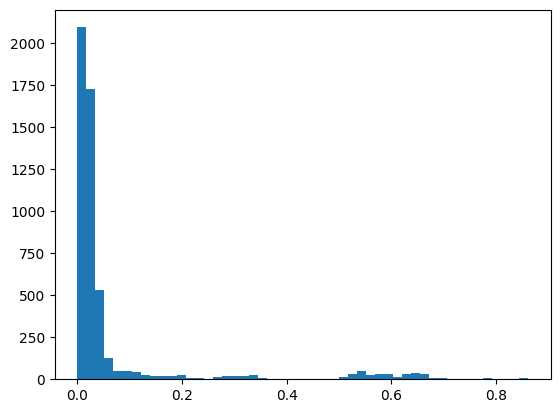

In [48]:
p2p_k.shape, corr_second.shape

sorted_distances = dist_y[p2p_k.cpu(), corr_second.cpu()].sort(descending=True)
print(sorted_distances)

plt.hist(sorted_distances.values, bins=50)
plt.show()

In [ ]:
mesh_1 = trimesh.Trimesh(data['first']['verts'].numpy(), data['first']['faces'].numpy())
mesh_2 = trimesh.Trimesh(data['second']['verts'].numpy() + [1, 0, 0], data['second']['faces'].numpy())
mesh_3 = trimesh.Trimesh(data['second']['verts'].numpy() + [2, 0, 0], data['second']['faces'].numpy())

print(data['first']['id'], data['second']['id'])

mesh_1.visual.vertex_colors = 255 * np.ones_like(mesh_1.vertices)
mesh_2.visual.vertex_colors = 255 * np.ones_like(mesh_2.vertices)
mesh_3.visual.vertex_colors = 255 * np.ones_like(mesh_3.vertices)

scene.geometry.clear()

for i, bad_index in enumerate(sorted_distances.indices[:1]):
    
    print(f'Bad index: {bad_index}, geo_err: {sorted_distances.values[i]*100:.2f}, corr: {corr_second[bad_index]}, p2p: {p2p_k[bad_index]}')
    
    mesh_1.visual.vertex_colors[bad_index.cpu()] = [255, 0, 0, 255]
    # mesh_2.visual.vertex_colors[corr_second[bad_index].cpu()] = [255, 0, 0, 255]
    # mesh_3.visual.vertex_colors[p2p_k[bad_index].cpu()] = [255, 0, 0, 255]
    
    # draw a small ball around the bad vertex
    
    sphere = trimesh.creation.uv_sphere(radius=0.03)
    sphere.vertices += mesh_2.vertices[corr_second[bad_index].cpu()]
    sphere.visual.vertex_colors = [0, 255, 0, 255]
    
    scene.add_geometry(sphere)
    
    
    sphere = trimesh.creation.uv_sphere(radius=0.03)
    sphere.vertices += mesh_3.vertices[p2p_k[bad_index].cpu()]
    sphere.visual.vertex_colors = [255, 0, 0, 255]
    
    scene.add_geometry(sphere)
    

scene.add_geometry(mesh_1)
scene.add_geometry(mesh_2)
scene.add_geometry(mesh_3)

scene.show()   
    

In [ ]:
import my_code.utils.plotting_utils as plotting_utils
import matplotlib.pyplot as plt

l = 0
h = 64

fig, axs = plt.subplots(1, 2, figsize=(8, 4))

plotting_utils.plot_Cxy(fig, axs[0],  Cxy_k.cpu(),
                        'fmnet', l, h, show_grid=False, show_colorbar=False)
plt.show()

In [164]:
import trimesh

# interpolate an array of colors
import numpy as np

def plot_double_p2p_map(
    scene,
    verts_first, verts_second,
    faces_first, faces_second,
    p2p_first, p2p_second,
):

    cmap = trimesh.visual.color.interpolate(
        (verts_first[:, 1] + verts_first[:, 0]).cpu()[p2p_first.cpu()],
        'jet')
    
    mesh_1 = trimesh.Trimesh(vertices=verts_first.cpu().numpy(), faces=faces_first.cpu().numpy())
    mesh_2 = trimesh.Trimesh(vertices=verts_second.cpu().numpy() + [1, 0, 0], faces=faces_second.cpu().numpy())

    mesh_1.visual.vertex_colors = np.ones_like(mesh_1.vertices) * 255
    mesh_1.visual.vertex_colors[p2p_first.cpu().numpy()] = cmap

    mesh_2.visual.vertex_colors = np.ones_like(mesh_2.vertices) * 255
    mesh_2.visual.vertex_colors[p2p_second.cpu().numpy()] = cmap

    scene.add_geometry(mesh_1)
    scene.add_geometry(mesh_2)
    
    return scene

In [ ]:
import trimesh

scene = trimesh.Scene()

scene = plot_double_p2p_map(
    scene,
    verts_first, verts_second,
    faces_first, faces_second,
    p2p_median_first_filtered, p2p_median_second_filtered,
    # p2p_est_first[5], p2p_est_second[5],
)

scene.show()

In [90]:
import sys

sys.path.append('/home/s94zalek_hpc/shape_matching/pyFM_fork')

import pyFM

# Fmap network

In [22]:
# import networks.fmap_network as fmap_network

# fmnet = fmap_network.RegularizedFMNet()

In [22]:
import networks.fmap_network as fmap_network
import torch.nn as nn


class RegularizedFMNet(nn.Module):
    """Compute the functional map matrix representation in DPFM"""
    def __init__(self, lmbda=0.01, resolvant_gamma=0.5, bidirectional=False):
        super(RegularizedFMNet, self).__init__()
        self.lmbda = lmbda
        self.resolvant_gamma = resolvant_gamma
        self.bidirectional = bidirectional

    def compute_functional_map(self, A, B, evals_x, evals_y):
        # A = torch.bmm(evecs_trans_x, feat_x)  # [B, K, C]
        # B = torch.bmm(evecs_trans_y, feat_y)  # [B, K, C]

        D = fmap_network.get_mask(evals_x, evals_y, self.resolvant_gamma)  # [B, K, K]

        A_t = A.transpose(1, 2)  # [B, C, K]
        A_A_t = torch.bmm(A, A_t)  # [B, K, K]
        B_A_t = torch.bmm(B, A_t)  # [B, K, K]

        C_i = []
        for i in range(evals_x.shape[1]):
            D_i = torch.cat([torch.diag(D[bs, i, :].flatten()).unsqueeze(0) for bs in range(evals_x.shape[0])], dim=0)
            C = torch.bmm(torch.inverse(A_A_t + self.lmbda * D_i), B_A_t[:, [i], :].transpose(1, 2))
            C_i.append(C.transpose(1, 2))

        Cxy = torch.cat(C_i, dim=1)
        
        # print('Cxy.shape', Cxy.shape)
        # print('Cxy', Cxy)
        # exit(0)
        
        return Cxy
    
fmnet = RegularizedFMNet()

In [23]:
# C_fmnet = fmnet.forward(
#     torch.ones_like(evecs_first_zo[:, :num_evecs][p2p_median_first_filtered].unsqueeze(0)),
#     torch.ones_like(evecs_second_zo[:, :num_evecs][p2p_median_second_filtered].unsqueeze(0)),
#     # torch.ones(1, p2p_median_first_filtered.shape[0], 64, device='cuda'),
#     # torch.ones(1, p2p_median_second_filtered.shape[0], 64,   device='cuda'),
#     evals_first.cuda().unsqueeze(0), evals_second.cuda().unsqueeze(0),
#     torch.pinverse(evecs_first_zo[:, :num_evecs])[:, p2p_median_first_filtered].unsqueeze(0),
#     torch.pinverse(evecs_second_zo[:, :num_evecs])[:, p2p_median_second_filtered].unsqueeze(0),
# )[0][0]


C_fmnet = fmnet.compute_functional_map(
    torch.pinverse(evecs_second_zo[:, :num_evecs])[:, p2p_median_second_filtered].unsqueeze(0),
    torch.pinverse(evecs_first_zo[:, :num_evecs])[:, p2p_median_first_filtered].unsqueeze(0),
    evals_second.cuda().unsqueeze(0),
    evals_first.cuda().unsqueeze(0), 
)[0]

Cxy_evecs = evecs_second_zo[p2p_median_second_filtered, :num_evecs].T @\
    (mass_second[p2p_median_second_filtered, None] * evecs_first_zo[p2p_median_first_filtered, :num_evecs])

Cxy_lstsq = torch.linalg.lstsq(
    evecs_second_zo[:, :num_evecs][p2p_median_second_filtered],
    evecs_first_zo[:, :num_evecs][p2p_median_first_filtered]
    ).solution

Cxy_gt = torch.linalg.lstsq(
    evecs_second_zo[:, :num_evecs][corr_second],
    evecs_first_zo[:, :num_evecs][corr_first]
    ).solution

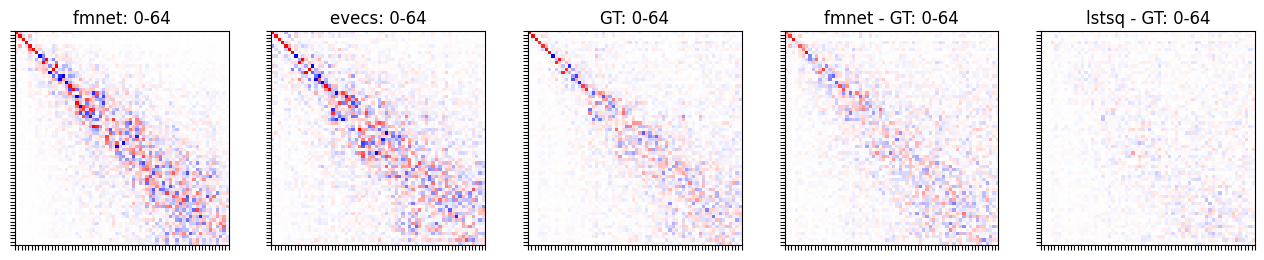

In [24]:
import my_code.utils.plotting_utils as plotting_utils
import matplotlib.pyplot as plt

l = 0
h = 64

fig, axs = plt.subplots(1, 5, figsize=(16, 4))

plotting_utils.plot_Cxy(fig, axs[0],  C_fmnet.cpu(),
                        'fmnet', l, h, show_grid=False, show_colorbar=False)
plotting_utils.plot_Cxy(fig, axs[1],  Cxy_evecs.cpu(),
                        'evecs', l, h, show_grid=False, show_colorbar=False)
plotting_utils.plot_Cxy(fig, axs[2],  Cxy_gt.cpu(),
                        'GT', l, h, show_grid=False, show_colorbar=False)
plotting_utils.plot_Cxy(fig, axs[3],  (C_fmnet.T - Cxy_gt).cpu(),
                        'fmnet - GT', l, h, show_grid=False, show_colorbar=False)
plotting_utils.plot_Cxy(fig, axs[4],  (Cxy_lstsq - Cxy_gt).cpu(),
                        'lstsq - GT', l, h, show_grid=False, show_colorbar=False)
plt.show()

In [29]:
geo_err, p2p_expanded, Cxy_est = get_geo_error(
    p2p_median_first_filtered, p2p_median_second_filtered,
    evecs_first_zo, evecs_second_zo,
    corr_first, corr_second,
    num_evecs, False,
    dist_x,
    regularized=True,
    evecs_trans_first=torch.pinverse(evecs_first_zo[:, :num_evecs]).to('cuda'),
    evecs_trans_second=torch.pinverse(evecs_second_zo[:, :num_evecs]).to('cuda'),
    evals_first=evals_first.to('cuda'),
    evals_second=evals_second.to('cuda'),
    return_p2p=True, return_Cxy=True    
    )
geo_err


# C_fmnet = fmnet.compute_functional_map(
#     torch.pinverse(evecs_second_zo[:, :num_evecs])[:, p2p_median_second].unsqueeze(0),
#     torch.pinverse(evecs_first_zo[:, :num_evecs])[:, p2p_median_first].unsqueeze(0),
#     evals_second.cuda().unsqueeze(0),
#     evals_first.cuda().unsqueeze(0), 
# )[0]

tensor(8.6116, dtype=torch.float64)

In [26]:
import importlib

importlib.reload(plotting_utils)

<module 'my_code.utils.plotting_utils' from '/home/s94zalek_hpc/shape_matching/my_code/utils/plotting_utils.py'>

In [ ]:
import my_code.utils.plotting_utils as plotting_utils

scene.geometry.clear()

plotting_utils.plot_p2p_map(
    scene,
    data['first']['verts'], data['first']['faces'],
    data['second']['verts'], data['second']['faces'],
    p2p_expanded,
    axes_color_gradient=[0,1 ],
    base_cmap='hsv'
)

scene.show()

# Are the conditioning evecs always the same?

In [ ]:

data_range = tqdm([0, 11, 43])
# 
# data_range = tqdm(range(2))
# print('!!! WARNING: only 2 samples are processed !!!')

# for i in data_range:

data = single_dataset[0]


device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'

verts_first = template_shape['verts'].unsqueeze(0).to(device)
verts_second = data['verts'].unsqueeze(0).to(device)

faces_first = template_shape['faces'].unsqueeze(0).to(device)
faces_second = data['faces'].unsqueeze(0).to(device)

evecs_first = template_shape['evecs'][:, :num_evecs].unsqueeze(0).to(device)
evecs_second = data['evecs'][:, :num_evecs].unsqueeze(0).to(device)

evals_first = template_shape['evals'][:num_evecs]
evals_second = data['evals'][:num_evecs]

# corr_first = data['first']['corr']
# corr_second = data['corr']

if config["sign_net"]["with_mass"]:
    mass_mat_first = torch.diag_embed(
        template_shape['mass'].unsqueeze(0)
        ).to(device)
    mass_mat_second = torch.diag_embed(
        data['mass'].unsqueeze(0)
        ).to(device)
else:
    mass_mat_first = None
    mass_mat_second = None


evecs_cond_first_list = []
evecs_cond_second_list = [
    
]
for _ in tqdm(range(100)):

    # predict the sign change
    with torch.no_grad():
        sign_pred_first, support_vector_norm_first, _ = predict_sign_change(
            sign_corr_net, verts_first, faces_first, evecs_first, 
            mass_mat=mass_mat_first, input_type=sign_corr_net.input_type,
            evecs_per_support=config["sign_net"]["evecs_per_support"],
            
            # mass=None, L=None, evals=None, evecs=None, gradX=None, gradY=None
            mass=template_shape['mass'].unsqueeze(0), L=template_shape['L'].unsqueeze(0),
            evals=template_shape['evals'][:config["sign_net"]["net_params"]["k_eig"]].unsqueeze(0),
            evecs=template_shape['evecs'][:,:config["sign_net"]["net_params"]["k_eig"]].unsqueeze(0),
            gradX=template_shape['gradX'].unsqueeze(0), gradY=template_shape['gradY'].unsqueeze(0)
            )
        sign_pred_second, support_vector_norm_second, _ = predict_sign_change(
            sign_corr_net, verts_second, faces_second, evecs_second, 
            mass_mat=mass_mat_second, input_type=sign_corr_net.input_type,
            evecs_per_support=config["sign_net"]["evecs_per_support"],
            
            # mass=None, L=None, evals=None, evecs=None, gradX=None, gradY=None
            mass=data['mass'].unsqueeze(0), L=data['L'].unsqueeze(0),
            evals=data['evals'][:config["sign_net"]["net_params"]["k_eig"]].unsqueeze(0),
            evecs=data['evecs'][:,:config["sign_net"]["net_params"]["k_eig"]].unsqueeze(0),
            gradX=data['gradX'].unsqueeze(0), gradY=data['gradY'].unsqueeze(0)
            )

    # correct the evecs
    evecs_first_corrected = evecs_first.cpu()[0] * torch.sign(sign_pred_first).cpu()
    evecs_first_corrected_norm = evecs_first_corrected / torch.norm(evecs_first_corrected, dim=0, keepdim=True)
    
    evecs_second_corrected = evecs_second.cpu()[0] * torch.sign(sign_pred_second).cpu()
    evecs_second_corrected_norm = evecs_second_corrected / torch.norm(evecs_second_corrected, dim=0, keepdim=True)
    
    # product with support
    # evecs_cond_first = evecs_first_corrected_norm.transpose(0, 1) @ support_vector_norm_first[0].cpu()
    # evecs_cond_second = evecs_second_corrected_norm.transpose(0, 1) @ support_vector_norm_second[0].cpu()


    # product with support
    if config["sign_net"]["with_mass"]:
    # if config["sign_net"]['cond_mass_normalize']:
        
        mass_mat_first = torch.diag_embed(
            template_shape['mass'].unsqueeze(0)
            ).to(device)
        mass_mat_second = torch.diag_embed(
            data['mass'].unsqueeze(0)
            ).to(device)
        
        evecs_cond_first = torch.nn.functional.normalize(
            support_vector_norm_first[0].cpu().transpose(0, 1) \
                @ mass_mat_first[0].cpu(),
            p=2, dim=1) \
                @ evecs_first_corrected_norm
        
        evecs_cond_second = torch.nn.functional.normalize(
            support_vector_norm_second[0].cpu().transpose(0, 1) \
                @ mass_mat_second[0].cpu(),
            p=2, dim=1) \
                @ evecs_second_corrected_norm 
        
    else:
        evecs_cond_first = support_vector_norm_first[0].cpu().transpose(0, 1) @ evecs_first_corrected_norm
        evecs_cond_second = support_vector_norm_second[0].cpu().transpose(0, 1) @ evecs_second_corrected_norm

    evecs_cond_first_list.append(evecs_cond_first)
    evecs_cond_second_list.append(evecs_cond_second)
    
evecs_cond_first_list = torch.stack(evecs_cond_first_list)
evecs_cond_second_list = torch.stack(evecs_cond_second_list)

In [ ]:
import my_code.utils.plotting_utils as plotting_utils
import matplotlib.pyplot as plt

idx_0 = torch.randint(0, 100, (1,)).item()
idx_1 = torch.randint(0, 100, (1,)).item()
idx_2 = torch.randint(0, 100, (1,)).item()

l = 0
h = 64

fig, axs = plt.subplots(1, 3, figsize=(15, 4))

plotting_utils.plot_Cxy(
    fig, axs[0], 
    (evecs_cond_second_list[idx_0] - evecs_cond_second_list[idx_1]).cpu(),
    f'{idx_0} - {idx_1}', l, h, show_grid=False, show_colorbar=False)

plotting_utils.plot_Cxy(
    fig, axs[1],
    (evecs_cond_second_list[idx_1] - evecs_cond_second_list[idx_2]).cpu(),
    f'{idx_1} - {idx_2}', l, h, show_grid=False, show_colorbar=False)

plotting_utils.plot_Cxy(
    fig, axs[2], 
    (evecs_cond_second_list[idx_0] - evecs_cond_second_list[idx_2]).cpu(),
    f'{idx_0} - {idx_2}', l, h, show_grid=False, show_colorbar=False)
plt.show()

# Check which meshes are problematic

In [109]:
# read the file /home/s94zalek_hpc/shape_matching/my_code/experiments/ddpm/single_64_2-2ev_64-128-128_remeshed/eval/epoch_99/SHREC19_r_pair-test/no_smoothing/log.txt

with open('/home/s94zalek_hpc/shape_matching/my_code/experiments/ddpm/'
          # 'single_64_2-2ev_64-128-128_remeshed/eval/epoch_99/SHREC19_r_pair-test/taubin-5/log_taubin-5.txt', 'r') as f:
        'single_64_2-2ev_64-128-128_remeshed/eval/epoch_99/SHREC19_r_pair-test/no_smoothing/log.txt', 'r') as f:
    lines = f.readlines()
len(lines)

# try with smoothing

5821

In [110]:
pairzo_errs = []

search_str = 'Geo error est pairzo mean: '

example_str = 'Geo error est pairzo mean: 2.233'

for line in lines:
    if 'Geo error est pairzo mean: ' in line:
        pairzo_errs.append(float(line.split(search_str)[1].strip()))
        
len(pairzo_errs)

407

In [111]:
shape_ids_first = []
shape_ids_second = []

for corr_file in test_dataset.corr_files:
    # 'data/SHREC19_r/corres/12_1.map'
    id_1 = int(corr_file.split('/')[-1].split('_')[0]) - 1
    id_2 = int(corr_file.split('/')[-1].split('_')[1].split('.')[0]) - 1
    
    shape_ids_first.append(id_1)
    shape_ids_second.append(id_2)

In [112]:
# set to 0, for each unique shape id

unique_shapes = set(shape_ids_first)

errs_by_shape = torch.zeros(44)
times_by_shape = torch.zeros(44)

for i in range(len(shape_ids_first)):
    # print(i)
    errs_by_shape[shape_ids_first[i]] += pairzo_errs[i]
    errs_by_shape[shape_ids_second[i]] += pairzo_errs[i]
    
    times_by_shape[shape_ids_first[i]] += 1
    times_by_shape[shape_ids_second[i]] += 1
    
errs_by_shape /= times_by_shape    


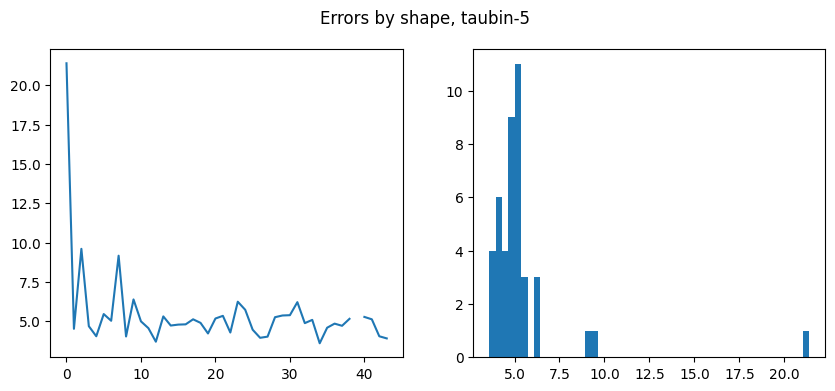

In [113]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].plot(errs_by_shape.numpy())
axs[1].hist(errs_by_shape.numpy(), bins=50)

# plt.label('Errors by shape, no smoothing')
# make a title above all subplots
fig.suptitle('Errors by shape, taubin-5')

plt.show()

In [114]:
errs_by_shape.sort(descending=True)

torch.return_types.sort(
values=tensor([    nan, 21.3947,  9.5984,  9.1617,  6.3810,  6.2364,  6.2082,  5.7225,
         5.4506,  5.3794,  5.3606,  5.3376,  5.3025,  5.2693,  5.2514,  5.1682,
         5.1483,  5.1179,  5.1175,  5.0810,  5.0247,  4.9871,  4.8907,  4.8745,
         4.8429,  4.7973,  4.7806,  4.7213,  4.7052,  4.6800,  4.5832,  4.5540,
         4.5133,  4.4553,  4.2776,  4.2168,  4.0400,  4.0392,  4.0269,  4.0161,
         3.9415,  3.9035,  3.6939,  3.5938]),
indices=tensor([39,  0,  2,  7,  9, 23, 31, 24,  5, 30, 29, 21, 13, 40, 28, 20, 38, 17,
        41, 33,  6, 10, 18, 32, 36, 16, 15, 14, 37,  3, 35, 11,  1, 25, 22, 19,
         4, 42,  8, 27, 26, 43, 12, 34]))

In [ ]:
pairzo_errs

In [33]:
errs_by_shape.argsort(descending=True)

tensor([39,  0,  2,  7,  9, 23, 31, 24,  5, 30, 29, 21, 13, 40, 28, 20, 38, 17,
        41, 33,  6, 10, 18, 32, 36, 16, 15, 14, 37,  3, 35, 11,  1, 25, 22, 19,
         4, 42,  8, 27, 26, 43, 12, 34])

In [ ]:
# add 4 random training shapes to trimesh scene

# np.random.shuffle(train_shapes)
scene.geometry.clear()

idx_train = errs_by_shape.argsort(descending=True)[1:]

for i, idx in enumerate(idx_train):
    scene.add_geometry(trimesh.Trimesh(
        vertices=single_dataset[idx]['verts'] + torch.tensor([i, 0, 0]),
        faces=single_dataset[idx]['faces']))
    
axis = trimesh.creation.axis(axis_length=1)
scene.add_geometry(axis)
scene.show()

In [47]:
test_dataset[124]['first']['id'], test_dataset[124]['second']['id']

(tensor(2), tensor(13))

In [ ]:
import my_code.utils.plotting_utils as plotting_utils
import matplotlib.pyplot as plt

l = 0
h = 64

fig, axs = plt.subplots(1, 2, figsize=(8, 4))

plotting_utils.plot_Cxy(fig, axs[0],  test_dataset[124]['second']['C_gt_xy'][0],
                        'fmnet', l, h, show_grid=False, show_colorbar=False)
plotting_utils.plot_Cxy(fig, axs[1],  test_dataset[124]['second']['C_gt_yx'][0],
                        'evecs', l, h, show_grid=False, show_colorbar=False)
plt.show()

# p2p map through permutation network

In [17]:
from networks.permutation_network import Similarity
from texture_transfer import compute_permutation_matrix

permutation = Similarity(tau=0.07, hard=True).to(device)


# dist_y[p2p_k.cpu(), corr_second.cpu()].sort(descending=True)

In [19]:
Pxy.shape

torch.Size([1, 64, 64])

In [21]:
Pxy, Pyx = compute_permutation_matrix(
    feat_x=evecs_first_zo[:, :][corr_first].unsqueeze(0),
    feat_y=evecs_second_zo[:, :][corr_second].unsqueeze(0),
    # torch.pinverse(evecs_second_zo[:, :num_evecs][corr_second]).unsqueeze(0).permute(0, 2, 1),
    # torch.pinverse(evecs_first_zo[:, :num_evecs][corr_first]).unsqueeze(0).permute(0, 2, 1),
    permutation=permutation,
    bidirectional=True
)
p2p_permutation = Pyx[0].argmax(dim=1)

geodist_metric.calculate_geodesic_error(
    dist_x, corr_first.cpu(), corr_second.cpu(), p2p_permutation.cpu(), return_mean=True
)

tensor(0.6246, dtype=torch.float64)

In [186]:
Pxy[0].sum(axis=1)

tensor([1., 1., 1.,  ..., 1., 1., 1.], device='cuda:0')

In [ ]:
import my_code.utils.plotting_utils as plotting_utils

scene.geometry.clear()

plotting_utils.plot_p2p_map(
    scene,
    data['first']['verts'], data['first']['faces'],
    data['second']['verts'], data['second']['faces'],
    p2p_permutation.cpu(),
    axes_color_gradient=[0,1 ],
    base_cmap='hsv'
)

scene.show()